This is a step by step implementation of the Stroke Width transform paper which describes the way to detect text in natural scenes

[Detecting Text in Natural Scenes with
Stroke Width Transform](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/1509.pdf)

In [206]:
from skimage.io import imread
from skimage.filters import gaussian

image = gaussian(imread('resources/sign.jpeg'), multichannel=False)

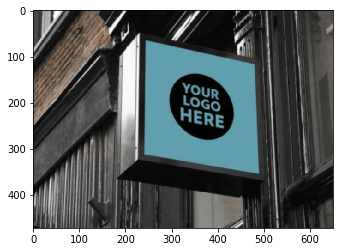

In [207]:
import matplotlib.pyplot as plt

plt.imshow(image)

In [208]:
#step 1 : color to gray
from skimage import feature
from skimage.color import rgb2gray

im = rgb2gray(image)

In [ ]:
#step 2: binarize and remove regions which may not have text


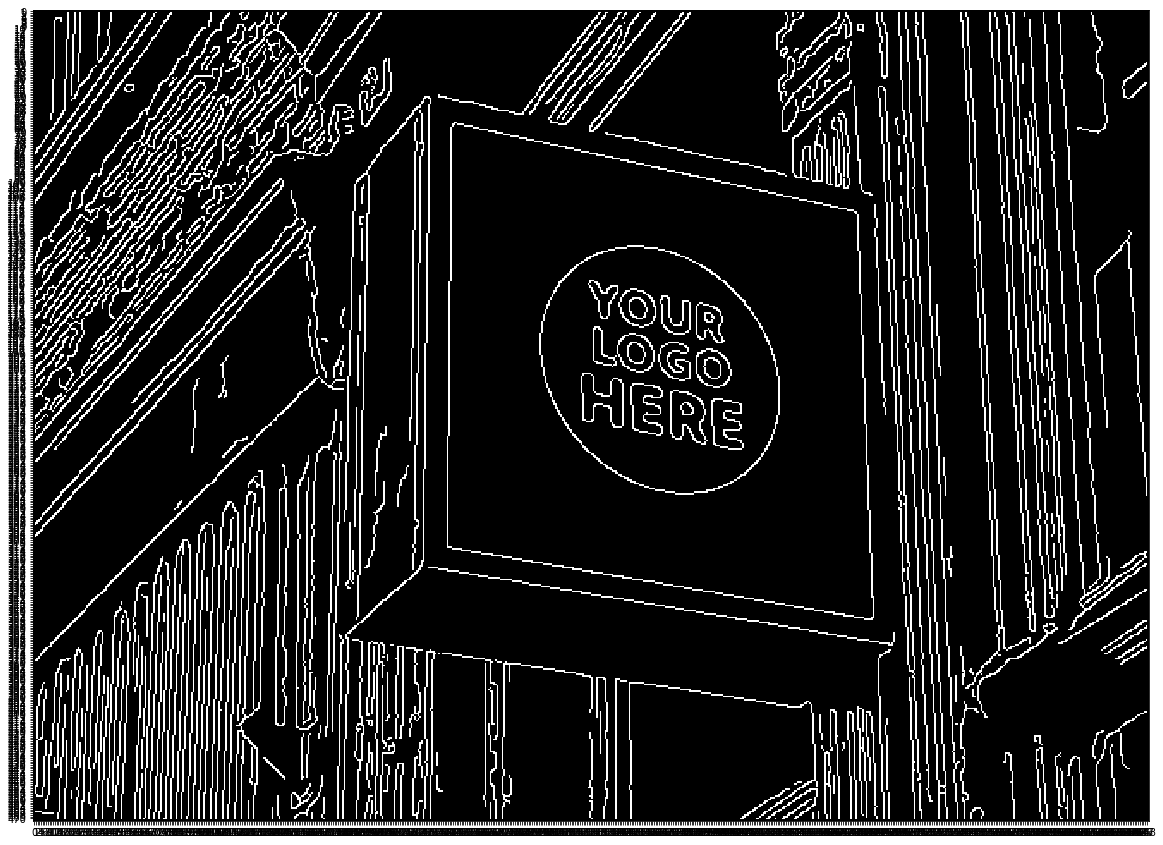

In [209]:
edges = feature.canny(im)
r,c = edges.shape

fig, ax = plt.subplots(figsize=(20,20))
# Customize the major grid
ax.set_xticks(np.arange(0, c-1,1))
ax.set_yticks(np.arange(0, r-1,1))
#ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.imshow(edges, cmap="gray")

/Users/muthukrishnan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/muthukrishnan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


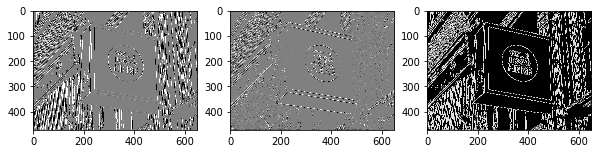

In [199]:
#Calculate the Gradient Images
from scipy import signal as sig
from skimage import feature
import numpy as np

##Define the Sobel operator kernels.
kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

gray_img = rgb2gray(image)
edges = feature.canny(gray_img)

G_x = sig.convolve2d(edges, kernel_x, mode='same') 
G_y = sig.convolve2d(edges, kernel_y, mode='same')

#Next, we can find the magnitude and direction of gradient.
magnitude = np.sqrt(G_x**2+G_y**2)
direction = np.arctan(G_y/G_x) * 57.2957795131 #inverse transform

fig, ax = plt.subplots(figsize=(10,10), ncols=3)
ax[0].imshow(G_x, cmap="gray")
ax[1].imshow(G_y, cmap="gray")
ax[2].imshow(magnitude, cmap="gray")

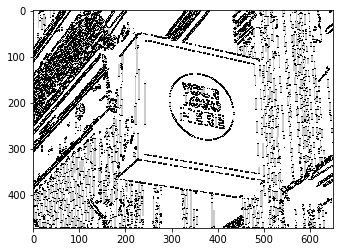

In [200]:
from skimage import img_as_ubyte
r,c = direction.shape
img_copy = np.zeros(image.shape)
zero_directions = []
ninety_directions = []
for ri in range(r):
    for ci in range(c):
        if np.isnan(direction[ri][ci]):
            img_copy[ri][ci] = 1
        elif int(direction[ri][ci]) == 90:
            img_copy[ri][ci] = 0.2
            ninety_directions.append([ri,ci])
        elif int(direction[ri][ci]) == 0:
            img_copy[ri][ci] = 0.8
            zero_directions.append([ri,ci])
        else:
            img_copy[ri][ci] = 0.0
plt.imshow(img_copy, cmap="gray")

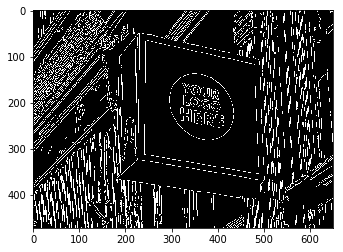

In [201]:
plt.imshow(edges, cmap="gray")

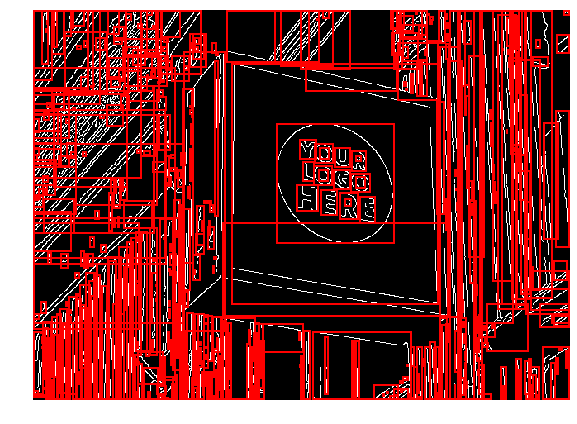

In [202]:
import matplotlib.patches as mpatches
from skimage.measure import label, regionprops

label_image = label(edges, connectivity=2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
ax.imshow(edges, cmap="gray")

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

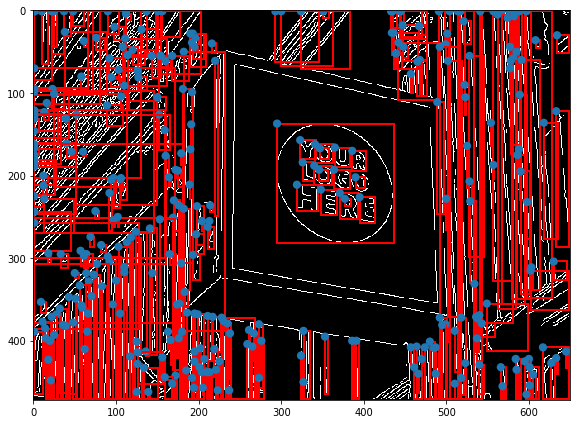

In [203]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(edges, cmap="gray")

text_like_regions = []
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    w = maxc - minc
    h = maxr - minr
    
    asr = w/h
    
    region_area = w*h
    
    wid,hei = edges.shape
    img_area = wid*hei
    
    # The aspect ratio is less than 1 to eliminate highly elongated regions
    # The size of the region should be greater than 15 pixels but smaller than 1/5th of the image
    # dimension to be considered for further processing
    if region_area > 15 and region_area < (0.2 * img_area) and asr < 1 and h > w:
        #print(w, h, i, region.area, region.bbox)
        text_like_regions.append(region)

all_points = []
for region in text_like_regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    circ = mpatches.Circle((minc, minr), radius=5)
    ax.add_patch(circ)
    all_points.append([minc, minr, maxc, maxr])
    
plt.tight_layout()
plt.show() 

In [192]:
from scipy.spatial.distance import euclidean
maxr, maxc = edges.shape

def find_vertical_next_pixel(pixel, maxr, pixel_value_to_check):
    pixel_found = False
    increment = 1
    point = None
    while(pixel[0]+increment < maxr-1 and pixel_found == False):
        if (edges[pixel[0]+increment, pixel[1]] == pixel_value_to_check):
            pixel_found = True
            point = [pixel[0]+increment,pixel[1]]
        increment = increment + 1
    return point

def find_horizontal_next_pixel(pixel, maxc, pixel_value_to_check):
    pixel_found = False
    increment = 1
    point = None
    while(pixel[1]+increment < maxc-1 and pixel_found == False):
        if (edges[pixel[1]+increment, pixel[1]] == pixel_value_to_check):
            pixel_found = True
            point = [pixel[1]+increment,pixel[1]]
        increment = increment + 1
    return point
        
for pixel in ninety_directions:
    point_1 = find_vertical_next_pixel(pixel,maxr, False)
    point_2 = find_vertical_next_pixel(point_1,maxr, True)
    if point_2 is not None and point_1 is not None:
        for index, p in enumerate(ninety_directions):
            if p[0] == point_2[0] and p[1] == point_2[1]:
                ninety_directions = np.delete(ninety_directions, index ,axis=0)
        print(euclidean(point_1, point_2))
        
for pixel in zero_directions:
    point_1 = find_horizontal_next_pixel(pixel,maxc, False)
    point_2 = find_horizontal_next_pixel(point_1,maxc, True)
    if point_2 is not None and point_1 is not None:
        for index, p in enumerate(ninety_directions):
            if p[0] == point_2[0] and p[1] == point_2[1]:
                ninety_directions = np.delete(ninety_directions, index ,axis=0)
        print(euclidean(point_1, point_2))

3.0
6.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
3.0
24.0
24.0
24.0
24.0
20.0
3.0
20.0
6.0
6.0
5.0
6.0
4.0
3.0
3.0
3.0
4.0
4.0
5.0
5.0
1.0
3.0
3.0
13.0
13.0
10.0
2.0
10.0
12.0
64.0
3.0
2.0
1.0
4.0
4.0
82.0
20.0
15.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
3.0
3.0
3.0
3.0
3.0
3.0
14.0
14.0
14.0
14.0
14.0
16.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
14.0
14.0
14.0
14.0
14.0
14.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
5.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
11.0
11.0
10.0
10.0
18.0
15.0
14.0
14.0
14.0
14.0
14.0
14.0
14.0
14.0
14.0
5.0
5.0
7.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
10.0
10.0
10.0
7.0
7.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
9.0
9.0
9.0
10.

3.0
3.0
3.0
3.0
3.0
3.0
10.0
10.0
9.0
9.0
9.0
9.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
2.0
3.0
4.0
4.0
4.0
4.0
2.0
2.0
3.0
3.0
3.0
1.0
3.0
3.0
1.0
2.0
3.0
4.0
4.0
10.0
10.0
10.0
10.0
9.0
9.0
9.0
9.0
8.0
8.0
8.0
7.0
3.0
2.0
6.0
11.0
10.0
5.0
5.0
5.0
5.0
5.0
5.0
6.0
2.0
2.0
10.0
2.0
2.0
2.0
3.0
3.0
1.0
2.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
2.0
1.0
6.0
6.0
6.0
6.0
6.0
6.0
6.0
2.0
5.0
5.0
1.0
3.0
3.0
3.0
3.0
2.0
2.0
2.0
2.0
2.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
3.0
3.0
3.0
3.0
2.0
3.0
8.0
8.0
24.0
24.0
24.0
24.0
24.0
24.0
23.0
23.0
23.0
3.0
2.0
4.0
4.0
4.0
4.0
4.0
3.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
2.0
2.0
2.0
2.0
2.0
3.0
3.0
3.0
3.0
3.0
2.0
2.0
2.0
1.0
4.0
4.0
4.0
4.0
3.0
6.0
7.0
2.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
3.0
4.0
4.0
2.0
2.0
2.0
2.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
21.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
22.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
4.0
4.0
6.0
5.0
5.0
3.0
3.0
2.0
9.0
7.0
6.0
6.0
6.0
6.0
9.0
2.0
2.0
4.0
1.0
3.0

3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
11.0
48.0
48.0
48.0
4.0
4.0
4.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
2.0
3.0
3.0
9.0
3.0
7.0
7.0
7.0
7.0
7.0
7.0
4.0
4.0
2.0
3.0
5.0
3.0
3.0
3.0
3.0
3.0
3.0
4.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
2.0
1.0
3.0
2.0
2.0
2.0
2.0
2.0
1.0
16.0
13.0
3.0
3.0
8.0
9.0
8.0
6.0
3.0
2.0
8.0
2.0
3.0
3.0
3.0
2.0
2.0
3.0
3.0
2.0
1.0
4.0
2.0
5.0
6.0
2.0
6.0
3.0
4.0
6.0
3.0
6.0
6.0
9.0
40.0
40.0
40.0
40.0
41.0
41.0
6.0
6.0
6.0
8.0
41.0
38.0
38.0
38.0
38.0
38.0
6.0
6.0
6.0
6.0
38.0
42.0
42.0
42.0
38.0
38.0
38.0
6.0
6.0
6.0
10.0
42.0
42.0
3.0
3.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
8.0
8.0
7.0
3.0
2.0
2.0
5.0
2.0
1.0
1.0
2.0
2.0
2.0
2.0
7.0
4.0
3.0
8.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
2.0
2.0
5.0
6.0
5.0
5.0
6.0
36.0
36.0
37.0
37.0
37.0
38.0
6.0
41.0
41.0
5.0
5.0
5.0
7.0
41.0
41.0
41.0
41.0
41.0
41.0
6.0
5.0
5.

9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
3.0
4.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
8.0
3.0
8.0
8.0
8.0
8.0
8.0
8.0
2.0
2.0
2.0
3.0
3.0
3.0
8.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
8.0
8.0
8.0
7.0
7.0
7.0
8.0
10.0
2.0
2.0
2.0
2.0
7.0
1.0
2.0
10.0
1.0
3.0
2.0
2.0
3.0
3.0
2.0
2.0
8.0
8.0
8.0
8.0
12.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
5.0
3.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
28.0
28.0
28.0
28.0
28.0
28.0
28.0
8.0
7.0
7.0
7.0
10.0
10.0
10.0
6.0
5.0
11.0
2.0
2.0
2.0
2.0
3.0
4.0
5.0
4.0
3.0
4.0
4.0
5.0
7.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
31.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0
33.0
33.0
33.0
33.0
2.0
2.0
3.0
4.0
5.0
7.0
8.0
10.0
2.0
2.0
2.0
2.0
2.0
20.0
15.0
16.0
18.0
27.0
29.0
2.0
2.0
2.0
2.0
5.0
26.0
27.0
28.0
30.0
31.0
32.0
33.0
34.0
35.0
1.0
1.0
1.0
1.0
1.0
41.0
40.0
40.0
39.0
39.0
39.0
38.0
37.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30

47.0
47.0
47.0
47.0
47.0
47.0
8.0
6.0
45.0
45.0
46.0
46.0
46.0
46.0
46.0
44.0
44.0
44.0
44.0
44.0
44.0
46.0
46.0
46.0
46.0
46.0
45.0
45.0
46.0
47.0
46.0
46.0
46.0
5.0
1.0
45.0
45.0
45.0
45.0
45.0
46.0
45.0
45.0
45.0
46.0
46.0
47.0
46.0
46.0
45.0
45.0
45.0
45.0
45.0
44.0
44.0
44.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
43.0
44.0
44.0
45.0
46.0
47.0
47.0
47.0
46.0
46.0
46.0
46.0
46.0
44.0
44.0
44.0
44.0
44.0
44.0
44.0
44.0
44.0
44.0
44.0
44.0
44.0
44.0
3.0
3.0
3.0
3.0
42.0
42.0
42.0
42.0
42.0
42.0
43.0
43.0
43.0
43.0
43.0
43.0
43.0
43.0
42.0
41.0
41.0
41.0
41.0
43.0
43.0
42.0
42.0
42.0
4.0
5.0
42.0
42.0
42.0
41.0
40.0
27.0
8.0
2.0
40.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
43.0
43.0
43.0
44.0
44.0
44.0
43.0
43.0
43.0
43.0
43.0
43.0
43.0
43.0
43.0
44.0
44.0
45.0
45.0
45.0
43.0
42.0
42.0
42.0
41.0
41.0
41.0
41.0
41.0
41.0
41.0

TypeError: 'NoneType' object is not subscriptable